In [135]:
import sys, io, random, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

In [136]:
%matplotlib inline

In [137]:
def genCities():
    cities = []
    for i in range(400):
        # nine center-points of city clusters
        ibox_x = (1.0/6.0) + random.randint(0,2) / 3.0
        ibox_y = (1.0/6.0) + random.randint(0,2) / 3.0
        x = random.random()/6.0 - (1.0/12.0) + ibox_x
        y = random.random()/6.0 - (1.0/12.0) + ibox_y
        cities.append( {'x' : x, 'y': y, 'id' : i} )
    #
    return pd.DataFrame(cities)

In [138]:
def plotCities(cities):
    cities.plot(x='x', y='y')

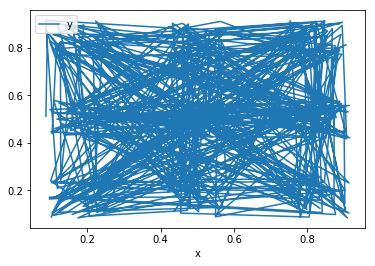

In [139]:
cities = genCities()
plotCities(cities)

In [140]:
def plotTSP(paths, points, num_iters=1):

    """
    path: List of lists with the different orders in which the nodes are visited
    points: coordinates for the different nodes
    num_iters: number of paths that are in the path list

    """

    # Unpack the primary TSP path and transform it into a list of ordered
    # coordinates

    x = []; y = []
    for i in paths[0]:
        x.append(points[i][0])
        y.append(points[i][1])

    plt.plot(x, y, 'co')

    # Set a scale for the arrow heads (there should be a reasonable default for this, WTF?)
    a_scale = float(max(x))/float(100)

    # Draw the older paths, if provided
    if num_iters > 1:

        for i in range(1, num_iters):

            # Transform the old paths into a list of coordinates
            xi = []; yi = [];
            for j in paths[i]:
                xi.append(points[j][0])
                yi.append(points[j][1])

            plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                    head_width = a_scale, color = 'r',
                    length_includes_head = True, ls = 'dashed',
                    width = 0.001/float(num_iters))
            for i in range(0, len(x) - 1):
                plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                        head_width = a_scale, color = 'r', length_includes_head = True,
                        ls = 'dashed', width = 0.001/float(num_iters))

    # Draw the primary path for the TSP problem
    plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
            color ='g', length_includes_head=True)
    for i in range(0,len(x)-1):
        plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                color = 'g', length_includes_head = True)

    #Set axis too slitghtly larger than the set of x and y
    plt.xlim(min(x)*1.1, max(x)*1.1)
    plt.ylim(min(y)*1.1, max(y)*1.1)
    plt.show()

In [157]:
# https://pdfs.semanticscholar.org/e893/4a942f06ee91940ab57732953ec6a24b3f00.pdf
class SimAnneal(object):
    def __init__(self, coords, T=-1, alpha=-1, stopping_T=-1, stopping_iter=-1, max_breadth=-1):
        self.coords = coords
        self.N = len(coords)
        self.T = math.sqrt(2.0 * self.N) if T == -1 else T
        self.T_save = self.T  # save inital T to reset if batch annealing is used
        self.alpha = 0.995 if alpha == -1 else alpha
        self.stopping_temperature = 1e-8 if stopping_T == -1 else stopping_T
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.max_breadth = int(math.floor(math.sqrt(self.N))) if max_breadth == -1 else max_breadth
        self.iteration = 1
        self.better_count = 0
        self.best_count = 0
        self.allow_count = 0

        self.nodes = [i for i in range(self.N)]

        self.solution_list = []
        
        self.initial_solution, self.initial_fitness = self.initial_solution()
        self.best_solution, self.best_fitness = self.initial_solution, self.initial_fitness
        self.solution_list.append( (self.initial_fitness, self.initial_solution) )
    #
    def initial_solution(self):
        """
        Greedy algorithm to get an initial solution (closest-neighbour).
        """
        cur_node = random.choice(self.nodes)  # start from a random node
        solution = [cur_node]

        free_nodes = set(self.nodes)
        free_nodes.remove(cur_node)
        while free_nodes:
            next_node = min(free_nodes, key=lambda x: self.dist(cur_node, x))  # nearest neighbour
            free_nodes.remove(next_node)
            solution.append(next_node)
            cur_node = next_node

        cur_fit = self.fitness(solution)
        self.solution_list.append( (cur_fit, solution) )
        return solution, cur_fit

    def dist(self, node_0, node_1):
        """
        Manhatan distance between two nodes.
        """
        coord_0, coord_1 = self.coords[node_0], self.coords[node_1]
        return abs(coord_0[0] - coord_1[0]) + abs(coord_0[1] - coord_1[1])

    def fitness(self, solution):
        """
        Total distance of the current solution path.
        """
        cur_fit = 0.0
        for i in range(self.N):
            cur_fit += self.dist(solution[i % self.N], solution[(i + 1) % self.N])
        return cur_fit/self.N

    def p_accept(self, candidate_fitness):
        """
        Probability of accepting if the candidate is worse than current.
        Depends on the current temperature and difference between candidate and current.
        """
        return math.exp(-abs(candidate_fitness - self.solution_list[-1][0]) / self.T)

    def accept(self, candidate):
        """
        Accept with probability 1 if candidate is better than current.
        Accept with probabilty p_accept(..) if candidate is worse.
        """
        accepted = False
        candidate_fitness = self.fitness(candidate)
        
        if candidate_fitness < self.solution_list[-1][0]:
            accepted = True
            self.better_count+=1
            if candidate_fitness < self.best_fitness:
                self.best_count+=1
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() < self.p_accept(candidate_fitness):
                accepted = True
                self.allow_count+=1
                
            
        return accepted, candidate_fitness

    def anneal(self):
        """
        Execute simulated annealing algorithm.
        """
        
        print("Starting annealing.")
        while self.T >= self.stopping_temperature and self.iteration < self.stopping_iter:
            accepted_list = []
            for tup in self.solution_list:
                candidate = tup[1].copy()
                l = random.randint(2, self.N - 1)
                i = random.randint(0, self.N - l)
                candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
                accepted, candidate_fitness = self.accept(candidate)
                if accepted:
                    accepted_list.append( (candidate_fitness, candidate) )
            #
            self.solution_list+=accepted_list
            self.T *= self.alpha
            self.iteration += 1
            
            if len(self.solution_list) > self.max_breadth:
                # sort by just the fitness values ... without trashing the array in the tuple
                fits = [tup[0] for tup in self.solution_list]
                self.solution_list = [self.solution_list[idx] for idx in np.argsort(fits) ]
                self.solution_list = self.solution_list[0:self.max_breadth]
            #
            print( [self.T, self.iteration, len(self.solution_list), self.best_fitness, self.best_count, self.better_count, self.allow_count] )
        #

        print("Best fitness obtained: ", self.best_fitness)
        improvement = self.initial_fitness / self.best_fitness
        print(f"Geometric improvement over greedy heuristic: {improvement : f}X")

    def batch_anneal(self, times=10):
        """
        Execute simulated annealing algorithm `times` times, with random initial solutions.
        """
        for i in range(1, times + 1):
            print(f"Iteration {i}/{times} -------------------------------")
            self.T = self.T_save
            self.iteration = 1
            self.cur_solution, self.cur_fitness = self.initial_solution()
            self.anneal()

    def visualize_routes(self):
        """
        Visualize the TSP route with matplotlib.
        """
        plotTSP([self.best_solution], self.coords)



In [158]:
coords = list(cities.as_matrix(columns=['x','y']))



/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


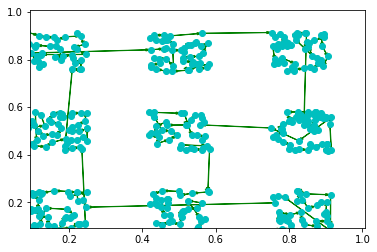

In [159]:
sa = SimAnneal(coords, stopping_iter=5000)
sa.visualize_routes()

In [160]:
sa.best_fitness

0.03514411579788351

In [161]:
sa.best_solution[0:10], sa.best_solution[-10:]

([14, 290, 130, 300, 77, 190, 221, 209, 225, 39],
 [247, 182, 59, 202, 358, 262, 277, 52, 116, 219])

Starting annealing.
[28.142849891224593, 2, 4, 0.03514411579788351, 0, 0, 2]
[28.00213564176847, 3, 8, 0.03514411579788351, 0, 0, 6]
[27.862124963559626, 4, 16, 0.03514411579788351, 0, 2, 12]
[27.722814338741827, 5, 20, 0.03514411579788351, 0, 9, 21]
[27.584200267048118, 6, 20, 0.03514411579788351, 0, 21, 29]
[27.446279265712878, 7, 20, 0.03514411579788351, 0, 30, 40]
[27.309047869384315, 8, 20, 0.03514411579788351, 0, 38, 52]
[27.172502630037393, 9, 20, 0.03514411579788351, 0, 46, 64]
[27.036640116887206, 10, 20, 0.03514411579788351, 0, 50, 80]
[26.90145691630277, 11, 20, 0.03514411579788351, 0, 51, 99]
[26.766949631721257, 12, 20, 0.03514411579788351, 0, 54, 116]
[26.63311488356265, 13, 20, 0.03514411579788351, 0, 57, 133]
[26.49994930914484, 14, 20, 0.03514411579788351, 0, 58, 152]
[26.367449562599113, 15, 20, 0.03514411579788351, 0, 59, 171]
[26.235612314786117, 16, 20, 0.03514411579788351, 0, 59, 191]
[26.104434253212187, 17, 20, 0.03514411579788351, 0, 61, 209]
[25.97391208194612

[13.811649228540178, 144, 20, 0.03514411579788351, 0, 163, 2646]
[13.742590982397477, 145, 20, 0.03514411579788351, 0, 163, 2665]
[13.67387802748549, 146, 20, 0.03514411579788351, 0, 163, 2685]
[13.605508637348063, 147, 20, 0.03514411579788351, 0, 163, 2705]
[13.537481094161322, 148, 20, 0.03514411579788351, 0, 163, 2725]
[13.469793688690515, 149, 20, 0.03514411579788351, 0, 164, 2744]
[13.402444720247063, 150, 20, 0.03514411579788351, 0, 164, 2764]
[13.335432496645828, 151, 20, 0.03514411579788351, 0, 164, 2784]
[13.268755334162599, 152, 20, 0.03514411579788351, 0, 164, 2804]
[13.202411557491786, 153, 20, 0.03514411579788351, 0, 164, 2824]
[13.136399499704327, 154, 20, 0.03508107689974091, 1, 167, 2841]
[13.070717502205804, 155, 20, 0.03508107689974091, 1, 169, 2859]
[13.005363914694776, 156, 20, 0.03508107689974091, 1, 170, 2878]
[12.940337095121302, 157, 20, 0.03508107689974091, 1, 170, 2898]
[12.875635409645696, 158, 20, 0.03508107689974091, 1, 170, 2918]
[12.811257232597468, 159, 

[6.915613016343889, 282, 20, 0.035001200256936434, 4, 196, 5372]
[6.88103495126217, 283, 20, 0.035001200256936434, 4, 196, 5392]
[6.846629776505859, 284, 20, 0.035001200256936434, 4, 196, 5412]
[6.81239662762333, 285, 20, 0.03495101656797395, 5, 197, 5431]
[6.778334644485213, 286, 20, 0.03495101656797395, 5, 198, 5450]
[6.744442971262787, 287, 20, 0.03495101656797395, 5, 198, 5470]
[6.710720756406473, 288, 20, 0.03495101656797395, 5, 198, 5490]
[6.67716715262444, 289, 20, 0.03495101656797395, 5, 198, 5510]
[6.643781316861318, 290, 20, 0.03495101656797395, 5, 198, 5530]
[6.610562410277011, 291, 20, 0.03495101656797395, 5, 198, 5550]
[6.577509598225626, 292, 20, 0.03495101656797395, 5, 198, 5570]
[6.544622050234498, 293, 20, 0.03495101656797395, 5, 198, 5590]
[6.511898939983325, 294, 20, 0.03495101656797395, 5, 198, 5610]
[6.479339445283409, 295, 20, 0.03495101656797395, 5, 199, 5629]
[6.446942748056991, 296, 20, 0.03495101656797395, 5, 199, 5649]
[6.414708034316706, 297, 20, 0.034951016

[3.293416321247236, 430, 20, 0.034951016567973926, 6, 225, 8301]
[3.276949239641, 431, 20, 0.034951016567973926, 6, 226, 8320]
[3.260564493442795, 432, 20, 0.034951016567973926, 6, 226, 8340]
[3.244261670975581, 433, 20, 0.034951016567973926, 6, 226, 8360]
[3.2280403626207033, 434, 20, 0.034951016567973926, 6, 226, 8380]
[3.2119001608075997, 435, 20, 0.034951016567973926, 6, 226, 8400]
[3.1958406600035616, 436, 20, 0.034951016567973926, 6, 226, 8420]
[3.1798614567035437, 437, 20, 0.034951016567973926, 6, 226, 8440]
[3.163962149420026, 438, 20, 0.034951016567973926, 6, 227, 8459]
[3.1481423386729257, 439, 20, 0.034951016567973926, 6, 227, 8479]
[3.132401626979561, 440, 20, 0.034951016567973926, 6, 227, 8499]
[3.116739618844663, 441, 20, 0.034951016567973926, 6, 227, 8519]
[3.1011559207504398, 442, 20, 0.034951016567973926, 6, 227, 8539]
[3.0856501411466875, 443, 20, 0.034951016567973926, 6, 227, 8559]
[3.070221890440954, 444, 20, 0.034951016567973926, 6, 227, 8579]
[3.054870780988749, 4

[1.6407970142139776, 569, 20, 0.03471133011944355, 8, 253, 11049]
[1.6325930291429078, 570, 20, 0.03471133011944355, 8, 253, 11069]
[1.6244300639971934, 571, 20, 0.03471133011944355, 8, 253, 11089]
[1.6163079136772074, 572, 20, 0.03471133011944355, 8, 253, 11109]
[1.6082263741088214, 573, 20, 0.03471133011944355, 8, 253, 11129]
[1.6001852422382774, 574, 20, 0.03471133011944355, 8, 253, 11149]
[1.592184316027086, 575, 20, 0.03471133011944355, 8, 253, 11169]
[1.5842233944469506, 576, 20, 0.03471133011944355, 8, 253, 11189]
[1.5763022774747157, 577, 20, 0.03471133011944355, 8, 254, 11208]
[1.5684207660873422, 578, 20, 0.03471133011944355, 8, 254, 11228]
[1.5605786622569053, 579, 20, 0.03471133011944355, 8, 255, 11247]
[1.5527757689456207, 580, 20, 0.03471133011944355, 8, 255, 11267]
[1.5450118901008927, 581, 20, 0.03471133011944355, 8, 255, 11287]
[1.5372868306503882, 582, 20, 0.03471133011944355, 8, 255, 11307]
[1.5296003964971363, 583, 20, 0.03471133011944355, 8, 255, 11327]
[1.52195239

[0.8052529471304873, 711, 20, 0.03470561591936077, 10, 280, 13855]
[0.8012266823948349, 712, 20, 0.03470561591936077, 10, 280, 13875]
[0.7972205489828607, 713, 20, 0.03470561591936077, 10, 280, 13895]
[0.7932344462379464, 714, 20, 0.03470561591936077, 10, 281, 13914]
[0.7892682740067566, 715, 20, 0.03470561591936077, 10, 281, 13934]
[0.7853219326367228, 716, 20, 0.03470561591936077, 10, 282, 13953]
[0.7813953229735392, 717, 20, 0.03470561591936077, 10, 283, 13972]
[0.7774883463586715, 718, 20, 0.03470561591936077, 10, 284, 13991]
[0.7736009046268781, 719, 20, 0.03470561591936077, 10, 284, 14011]
[0.7697329001037437, 720, 20, 0.03470561591936077, 10, 284, 14031]
[0.765884235603225, 721, 20, 0.03470561591936077, 10, 284, 14051]
[0.762054814425209, 722, 20, 0.03470561591936077, 10, 284, 14071]
[0.7582445403530829, 723, 20, 0.03470561591936077, 10, 284, 14091]
[0.7544533176513174, 724, 20, 0.03470561591936077, 10, 285, 14110]
[0.7506810510630608, 725, 20, 0.03470561591936077, 10, 285, 1413

[0.4175955870966737, 842, 20, 0.03466893502587011, 12, 309, 16434]
[0.41550760916119034, 843, 20, 0.03466893502587011, 12, 309, 16454]
[0.4134300711153844, 844, 20, 0.03466893502587011, 12, 310, 16473]
[0.41136292075980746, 845, 20, 0.03466893502587011, 12, 311, 16491]
[0.40930610615600843, 846, 20, 0.03466893502587011, 12, 312, 16509]
[0.4072595756252284, 847, 20, 0.03466893502587011, 12, 312, 16527]
[0.40522327774710226, 848, 20, 0.03466893502587011, 12, 312, 16547]
[0.40319716135836675, 849, 20, 0.03466893502587011, 12, 312, 16566]
[0.4011811755515749, 850, 20, 0.03466893502587011, 12, 312, 16586]
[0.399175269673817, 851, 20, 0.03466893502587011, 12, 312, 16605]
[0.39717939332544794, 852, 20, 0.03466893502587011, 12, 312, 16625]
[0.3951934963588207, 853, 20, 0.03461192906997879, 13, 313, 16644]
[0.39321752887702655, 854, 20, 0.03461192906997879, 13, 313, 16664]
[0.3912514412326414, 855, 20, 0.03461192906997879, 13, 313, 16684]
[0.38929518402647817, 856, 20, 0.03461192906997879, 13, 

[0.17810644180065122, 1012, 20, 0.03458823810374458, 15, 345, 19757]
[0.17721590959164796, 1013, 20, 0.03458823810374458, 15, 345, 19777]
[0.1763298300436897, 1014, 20, 0.03458823810374458, 15, 345, 19797]
[0.17544818089347125, 1015, 20, 0.03458823810374458, 15, 345, 19817]
[0.1745709399890039, 1016, 20, 0.03458823810374458, 15, 345, 19837]
[0.17369808528905886, 1017, 20, 0.03458823810374458, 15, 345, 19857]
[0.17282959486261357, 1018, 20, 0.03458823810374458, 15, 345, 19877]
[0.1719654468883005, 1019, 20, 0.03458823810374458, 15, 345, 19897]
[0.171105619653859, 1020, 20, 0.03458823810374458, 15, 345, 19917]
[0.1702500915555897, 1021, 20, 0.03458823810374458, 15, 345, 19936]
[0.16939884109781175, 1022, 20, 0.03458823810374458, 15, 345, 19956]
[0.1685518468923227, 1023, 20, 0.03458823810374458, 15, 345, 19976]
[0.16770908765786108, 1024, 20, 0.03458823810374458, 15, 345, 19995]
[0.16687054221957176, 1025, 20, 0.03458823810374458, 15, 346, 20014]
[0.1660361895084739, 1026, 20, 0.03458823

[0.09376353294059021, 1140, 20, 0.03455224802924345, 16, 363, 22231]
[0.09329471527588726, 1141, 20, 0.03455224802924345, 16, 363, 22251]
[0.09282824169950782, 1142, 20, 0.03455224802924345, 16, 363, 22271]
[0.09236410049101028, 1143, 20, 0.03455224802924345, 16, 363, 22289]
[0.09190227998855523, 1144, 20, 0.03455224802924345, 16, 363, 22308]
[0.09144276858861244, 1145, 20, 0.03455224802924345, 16, 363, 22328]
[0.09098555474566938, 1146, 20, 0.03455224802924345, 16, 363, 22347]
[0.09053062697194103, 1147, 20, 0.03455224802924345, 16, 363, 22367]
[0.09007797383708133, 1148, 20, 0.03455224802924345, 16, 363, 22385]
[0.08962758396789591, 1149, 20, 0.03455224802924345, 16, 363, 22404]
[0.08917944604805643, 1150, 20, 0.03455224802924345, 16, 363, 22424]
[0.08873354881781614, 1151, 20, 0.03455224802924345, 16, 363, 22444]
[0.08828988107372707, 1152, 20, 0.03455224802924345, 16, 363, 22462]
[0.08784843166835843, 1153, 20, 0.03455224802924345, 16, 364, 22480]
[0.08740918951001664, 1154, 20, 0.

[0.04624750926041577, 1281, 20, 0.0345022488964504, 19, 376, 24920]
[0.04601627171411369, 1282, 20, 0.0345022488964504, 19, 376, 24940]
[0.04578619035554312, 1283, 20, 0.0345022488964504, 19, 376, 24957]
[0.045557259403765406, 1284, 20, 0.0345022488964504, 19, 377, 24976]
[0.04532947310674658, 1285, 20, 0.0345022488964504, 19, 377, 24994]
[0.04510282574121285, 1286, 20, 0.0345022488964504, 19, 377, 25013]
[0.044877311612506784, 1287, 20, 0.0345022488964504, 19, 377, 25032]
[0.04465292505444425, 1288, 20, 0.0345022488964504, 19, 377, 25050]
[0.04442966042917203, 1289, 20, 0.0345022488964504, 19, 377, 25070]
[0.044207512127026165, 1290, 20, 0.0345022488964504, 19, 377, 25088]
[0.043986474566391036, 1291, 20, 0.0345022488964504, 19, 377, 25108]
[0.04376654219355908, 1292, 20, 0.0345022488964504, 19, 378, 25126]
[0.04354770948259128, 1293, 20, 0.0345022488964504, 19, 378, 25144]
[0.043329970935178326, 1294, 20, 0.0345022488964504, 19, 378, 25161]
[0.043113321080502434, 1295, 20, 0.03450224

[0.02362550867404405, 1415, 20, 0.03449115759771184, 20, 399, 27340]
[0.02350738113067383, 1416, 20, 0.03449115759771184, 20, 399, 27357]
[0.02338984422502046, 1417, 20, 0.03449115759771184, 20, 399, 27374]
[0.023272895003895358, 1418, 20, 0.03449115759771184, 20, 399, 27393]
[0.023156530528875882, 1419, 20, 0.03449115759771184, 20, 400, 27408]
[0.023040747876231504, 1420, 20, 0.03449115759771184, 20, 401, 27423]
[0.022925544136850346, 1421, 20, 0.03449115759771184, 20, 401, 27442]
[0.022810916416166095, 1422, 20, 0.03449115759771184, 20, 401, 27460]
[0.022696861834085265, 1423, 20, 0.03449115759771184, 20, 401, 27480]
[0.02258337752491484, 1424, 20, 0.03449115759771184, 20, 401, 27498]
[0.022470460637290263, 1425, 20, 0.03449115759771184, 20, 401, 27516]
[0.022358108334103812, 1426, 20, 0.03449115759771184, 20, 401, 27533]
[0.022246317792433294, 1427, 20, 0.03449115759771184, 20, 401, 27551]
[0.022135086203471127, 1428, 20, 0.03449115759771184, 20, 402, 27567]
[0.022024410772453772, 1

[0.011711498641202033, 1555, 20, 0.03449115759771184, 20, 421, 29682]
[0.011652941147996023, 1556, 20, 0.03449115759771184, 20, 421, 29697]
[0.011594676442256042, 1557, 20, 0.03449115759771184, 20, 421, 29709]
[0.011536703060044761, 1558, 20, 0.03445963245019278, 21, 422, 29726]
[0.011479019544744538, 1559, 20, 0.03445963245019278, 21, 422, 29743]
[0.011421624447020814, 1560, 20, 0.03445963245019278, 21, 423, 29754]
[0.01136451632478571, 1561, 20, 0.03445963245019278, 21, 423, 29768]
[0.011307693743161781, 1562, 20, 0.03445963245019278, 21, 423, 29784]
[0.011251155274445972, 1563, 20, 0.03445963245019278, 21, 423, 29803]
[0.011194899498073741, 1564, 20, 0.03445963245019278, 21, 423, 29818]
[0.011138925000583373, 1565, 20, 0.03445963245019278, 21, 423, 29834]
[0.011083230375580455, 1566, 20, 0.03445963245019278, 21, 423, 29847]
[0.011027814223702553, 1567, 20, 0.03445963245019278, 21, 423, 29863]
[0.01097267515258404, 1568, 20, 0.03445963245019278, 21, 423, 29877]
[0.01091781177682112, 

[0.006012875498753413, 1688, 20, 0.03443543059527353, 22, 435, 31590]
[0.005982811121259646, 1689, 20, 0.03443543059527353, 22, 435, 31605]
[0.005952897065653348, 1690, 20, 0.03443543059527353, 22, 435, 31620]
[0.005923132580325081, 1691, 20, 0.03443543059527353, 22, 435, 31636]
[0.0058935169174234555, 1692, 20, 0.03443543059527353, 22, 435, 31650]
[0.005864049332836338, 1693, 20, 0.03443543059527353, 22, 435, 31665]
[0.0058347290861721565, 1694, 20, 0.03443543059527353, 22, 435, 31679]
[0.0058055554407412955, 1695, 20, 0.03443543059527353, 22, 435, 31695]
[0.005776527663537589, 1696, 20, 0.03443543059527353, 22, 435, 31708]
[0.005747645025219901, 1697, 20, 0.03443543059527353, 22, 435, 31718]
[0.005718906800093801, 1698, 20, 0.03443543059527353, 22, 435, 31731]
[0.005690312266093333, 1699, 20, 0.03443543059527353, 22, 435, 31746]
[0.005661860704762866, 1700, 20, 0.03443543059527353, 22, 435, 31761]
[0.005633551401239051, 1701, 20, 0.03443543059527353, 22, 436, 31772]
[0.00560538364423

[0.002551696506616194, 1859, 20, 0.03434003967137369, 25, 454, 33370]
[0.002538938024083113, 1860, 20, 0.03434003967137369, 25, 454, 33378]
[0.0025262433339626974, 1861, 20, 0.03434003967137369, 25, 454, 33386]
[0.002513612117292884, 1862, 20, 0.03434003967137369, 25, 454, 33393]
[0.0025010440567064195, 1863, 20, 0.03434003967137369, 25, 454, 33397]
[0.0024885388364228873, 1864, 20, 0.03434003967137369, 25, 454, 33406]
[0.0024760961422407727, 1865, 20, 0.03434003967137369, 25, 454, 33412]
[0.002463715661529569, 1866, 20, 0.03434003967137369, 25, 454, 33420]
[0.0024513970832219212, 1867, 20, 0.03434003967137369, 25, 456, 33426]
[0.0024391400978058114, 1868, 20, 0.03434003967137369, 25, 456, 33434]
[0.0024269443973167822, 1869, 20, 0.03434003967137369, 25, 456, 33444]
[0.0024148096753301984, 1870, 20, 0.03434003967137369, 25, 458, 33450]
[0.0024027356269535473, 1871, 20, 0.03434003967137369, 25, 458, 33455]
[0.0023907219488187794, 1872, 20, 0.03434003967137369, 25, 458, 33462]
[0.0023787

[0.0012840770417686996, 1996, 20, 0.034223923095337755, 26, 486, 34139]
[0.001277656656559856, 1997, 20, 0.034223923095337755, 26, 487, 34143]
[0.0012712683732770567, 1998, 20, 0.034223923095337755, 26, 487, 34146]
[0.0012649120314106714, 1999, 20, 0.034223923095337755, 26, 488, 34151]
[0.001258587471253618, 2000, 20, 0.034223923095337755, 26, 488, 34154]
[0.0012522945338973499, 2001, 20, 0.034223923095337755, 26, 488, 34156]
[0.0012460330612278632, 2002, 20, 0.034223923095337755, 26, 489, 34159]
[0.0012398028959217239, 2003, 20, 0.034223923095337755, 26, 489, 34165]
[0.0012336038814421153, 2004, 20, 0.034223923095337755, 26, 489, 34166]
[0.0012274358620349046, 2005, 20, 0.034223923095337755, 26, 489, 34172]
[0.00122129868272473, 2006, 20, 0.034223923095337755, 26, 490, 34179]
[0.0012151921893111064, 2007, 20, 0.034223923095337755, 26, 490, 34184]
[0.0012091162283645509, 2008, 20, 0.034223923095337755, 26, 491, 34187]
[0.0012030706472227282, 2009, 20, 0.034223923095337755, 26, 491, 341

[0.0006862402299698928, 2121, 20, 0.03419370111752662, 29, 513, 34485]
[0.0006828090288200433, 2122, 20, 0.03419370111752662, 29, 513, 34487]
[0.000679394983675943, 2123, 20, 0.03419370111752662, 29, 513, 34490]
[0.0006759980087575633, 2124, 20, 0.03419370111752662, 29, 513, 34491]
[0.0006726180187137755, 2125, 20, 0.03419370111752662, 29, 513, 34492]
[0.0006692549286202065, 2126, 20, 0.03419370111752662, 29, 513, 34494]
[0.0006659086539771055, 2127, 20, 0.03419370111752662, 29, 513, 34495]
[0.00066257911070722, 2128, 20, 0.03419370111752662, 29, 513, 34495]
[0.000659266215153684, 2129, 20, 0.03419370111752662, 29, 513, 34496]
[0.0006559698840779155, 2130, 20, 0.03419370111752662, 29, 513, 34496]
[0.0006526900346575259, 2131, 20, 0.03419370111752662, 29, 513, 34497]
[0.0006494265844842383, 2132, 20, 0.03419370111752662, 29, 513, 34497]
[0.0006461794515618171, 2133, 20, 0.03419370111752662, 29, 513, 34499]
[0.000642948554304008, 2134, 20, 0.03419370111752662, 29, 514, 34500]
[0.00063973

[0.0003268075828329309, 2269, 20, 0.03409604212564765, 31, 535, 34680]
[0.0003251735449187662, 2270, 20, 0.03409604212564765, 31, 535, 34681]
[0.00032354767719417236, 2271, 20, 0.03409604212564765, 31, 535, 34681]
[0.0003219299388082015, 2272, 20, 0.03409604212564765, 31, 535, 34681]
[0.00032032028911416053, 2273, 20, 0.03409604212564765, 31, 535, 34681]
[0.0003187186876685897, 2274, 20, 0.03409604212564765, 31, 535, 34683]
[0.0003171250942302468, 2275, 20, 0.03409604212564765, 31, 535, 34683]
[0.00031553946875909555, 2276, 20, 0.03409604212564765, 31, 535, 34683]
[0.00031396177141530004, 2277, 20, 0.034021519675613184, 32, 536, 34683]
[0.00031239196255822353, 2278, 20, 0.034021519675613184, 32, 537, 34684]
[0.0003108300027454324, 2279, 20, 0.034021519675613184, 32, 537, 34686]
[0.00030927585273170526, 2280, 20, 0.034021519675613184, 32, 538, 34686]
[0.00030772947346804675, 2281, 20, 0.034021519675613184, 32, 538, 34686]
[0.0003061908261007065, 2282, 20, 0.034021519675613184, 32, 539, 

[0.00013323661125156245, 2448, 20, 0.03401869104390184, 34, 578, 34792]
[0.00013257042819530464, 2449, 20, 0.03401869104390184, 34, 578, 34793]
[0.0001319075760543281, 2450, 20, 0.03401869104390184, 34, 578, 34793]
[0.00013124803817405646, 2451, 20, 0.03401869104390184, 34, 579, 34793]
[0.00013059179798318617, 2452, 20, 0.03401869104390184, 34, 579, 34793]
[0.00012993883899327025, 2453, 20, 0.03401869104390184, 34, 579, 34793]
[0.0001292891447983039, 2454, 20, 0.03401869104390184, 34, 579, 34793]
[0.00012864269907431237, 2455, 20, 0.03401869104390184, 34, 579, 34794]
[0.0001279994855789408, 2456, 20, 0.03401869104390184, 34, 579, 34794]
[0.0001273594881510461, 2457, 20, 0.03401869104390184, 34, 580, 34794]
[0.00012672269071029087, 2458, 20, 0.03401869104390184, 34, 581, 34795]
[0.0001260890772567394, 2459, 20, 0.03401869104390184, 34, 581, 34796]
[0.0001254586318704557, 2460, 20, 0.03401869104390184, 34, 581, 34796]
[0.00012483133871110343, 2461, 20, 0.03401869104390184, 34, 581, 34797

[5.431940845410276e-05, 2627, 20, 0.033970259917268264, 36, 600, 34838]
[5.404781141183225e-05, 2628, 20, 0.033970259917268264, 36, 600, 34838]
[5.3777572354773084e-05, 2629, 20, 0.033970259917268264, 36, 600, 34838]
[5.350868449299922e-05, 2630, 20, 0.033970259917268264, 36, 601, 34838]
[5.324114107053422e-05, 2631, 20, 0.033970259917268264, 36, 603, 34839]
[5.2974935365181554e-05, 2632, 20, 0.033970259917268264, 36, 604, 34839]
[5.271006068835565e-05, 2633, 20, 0.033970259917268264, 36, 604, 34839]
[5.244651038491387e-05, 2634, 20, 0.033970259917268264, 36, 604, 34839]
[5.21842778329893e-05, 2635, 20, 0.033970259917268264, 36, 604, 34839]
[5.192335644382436e-05, 2636, 20, 0.033970259917268264, 36, 604, 34839]
[5.1663739661605236e-05, 2637, 20, 0.033970259917268264, 36, 605, 34839]
[5.140542096329721e-05, 2638, 20, 0.033970259917268264, 36, 605, 34839]
[5.114839385848072e-05, 2639, 20, 0.033970259917268264, 36, 605, 34839]
[5.0892651889188314e-05, 2640, 20, 0.033970259917268264, 36, 6

[2.7888475267494096e-05, 2760, 20, 0.033947032253051124, 37, 620, 34851]
[2.7749032891156627e-05, 2761, 20, 0.033947032253051124, 37, 621, 34851]
[2.7610287726700845e-05, 2762, 20, 0.033947032253051124, 37, 621, 34851]
[2.747223628806734e-05, 2763, 20, 0.033947032253051124, 37, 621, 34851]
[2.7334875106627004e-05, 2764, 20, 0.033947032253051124, 37, 621, 34851]
[2.719820073109387e-05, 2765, 20, 0.033947032253051124, 37, 621, 34851]
[2.7062209727438398e-05, 2766, 20, 0.033947032253051124, 37, 621, 34851]
[2.6926898678801205e-05, 2767, 20, 0.033947032253051124, 37, 621, 34851]
[2.67922641854072e-05, 2768, 20, 0.033947032253051124, 37, 621, 34851]
[2.6658302864480163e-05, 2769, 20, 0.033947032253051124, 37, 621, 34851]
[2.6525011350157763e-05, 2770, 20, 0.033947032253051124, 37, 621, 34851]
[2.6392386293406975e-05, 2771, 20, 0.033947032253051124, 37, 621, 34851]
[2.626042436193994e-05, 2772, 20, 0.033947032253051124, 37, 621, 34851]
[2.612912224013024e-05, 2773, 20, 0.033947032253051124, 

[1.44626657301424e-05, 2891, 20, 0.03392767763694712, 38, 638, 34854]
[1.4390352401491688e-05, 2892, 20, 0.03392767763694712, 38, 638, 34854]
[1.431840063948423e-05, 2893, 20, 0.03392767763694712, 38, 638, 34854]
[1.4246808636286809e-05, 2894, 20, 0.03392767763694712, 38, 638, 34854]
[1.4175574593105374e-05, 2895, 20, 0.03392767763694712, 38, 638, 34854]
[1.4104696720139847e-05, 2896, 20, 0.03392767763694712, 38, 638, 34854]
[1.4034173236539148e-05, 2897, 20, 0.03392767763694712, 38, 638, 34854]
[1.3964002370356451e-05, 2898, 20, 0.03392767763694712, 38, 638, 34854]
[1.389418235850467e-05, 2899, 20, 0.033927677636947116, 39, 639, 34854]
[1.3824711446712146e-05, 2900, 20, 0.033927677636947116, 39, 639, 34854]
[1.3755587889478585e-05, 2901, 20, 0.033927677636947116, 39, 639, 34855]
[1.3686809950031192e-05, 2902, 20, 0.033927677636947116, 39, 639, 34855]
[1.3618375900281036e-05, 2903, 20, 0.033927677636947116, 39, 639, 34855]
[1.3550284020779632e-05, 2904, 20, 0.033927677636947116, 39, 63

[7.537873512287179e-06, 3021, 20, 0.0338710527883036, 41, 656, 34858]
[7.500184144725743e-06, 3022, 20, 0.0338710527883036, 41, 656, 34858]
[7.462683224002114e-06, 3023, 20, 0.0338710527883036, 41, 656, 34858]
[7.425369807882104e-06, 3024, 20, 0.0338710527883036, 41, 656, 34858]
[7.388242958842694e-06, 3025, 20, 0.0338710527883036, 41, 656, 34858]
[7.35130174404848e-06, 3026, 20, 0.0338710527883036, 41, 656, 34858]
[7.314545235328237e-06, 3027, 20, 0.0338710527883036, 41, 656, 34858]
[7.277972509151596e-06, 3028, 20, 0.0338710527883036, 41, 657, 34858]
[7.241582646605838e-06, 3029, 20, 0.0338710527883036, 41, 657, 34858]
[7.205374733372809e-06, 3030, 20, 0.0338710527883036, 41, 657, 34858]
[7.169347859705945e-06, 3031, 20, 0.0338710527883036, 41, 658, 34858]
[7.1335011204074154e-06, 3032, 20, 0.0338710527883036, 41, 659, 34858]
[7.097833614805379e-06, 3033, 20, 0.0338710527883036, 41, 659, 34858]
[7.062344446731352e-06, 3034, 20, 0.0338710527883036, 41, 659, 34858]
[7.027032724497695e-

[3.4833994619998106e-06, 3175, 20, 0.03376469219603747, 43, 683, 34861]
[3.4659824646898116e-06, 3176, 20, 0.03376469219603747, 43, 683, 34861]
[3.4486525523663624e-06, 3177, 20, 0.03376469219603747, 43, 683, 34861]
[3.431409289604531e-06, 3178, 20, 0.03376469219603747, 43, 683, 34861]
[3.414252243156508e-06, 3179, 20, 0.03376469219603747, 43, 684, 34861]
[3.3971809819407256e-06, 3180, 20, 0.03376469219603747, 43, 685, 34861]
[3.380195077031022e-06, 3181, 20, 0.03376469219603747, 43, 685, 34861]
[3.3632941016458666e-06, 3182, 20, 0.03376469219603747, 43, 685, 34861]
[3.3464776311376373e-06, 3183, 20, 0.03376469219603747, 43, 685, 34861]
[3.329745242981949e-06, 3184, 20, 0.03376469219603747, 43, 685, 34861]
[3.313096516767039e-06, 3185, 20, 0.03376469219603747, 43, 685, 34861]
[3.2965310341832037e-06, 3186, 20, 0.03376469219603747, 43, 685, 34861]
[3.2800483790122877e-06, 3187, 20, 0.03376469219603747, 43, 685, 34861]
[3.2636481371172264e-06, 3188, 20, 0.03376469219603747, 43, 685, 3486

[1.918447368903806e-06, 3294, 20, 0.03373528567182321, 44, 699, 34861]
[1.908855132059287e-06, 3295, 20, 0.03373528567182321, 44, 700, 34861]
[1.8993108563989908e-06, 3296, 20, 0.03373528567182321, 44, 700, 34861]
[1.8898143021169959e-06, 3297, 20, 0.03373528567182321, 44, 700, 34861]
[1.880365230606411e-06, 3298, 20, 0.03373528567182321, 44, 700, 34861]
[1.8709634044533788e-06, 3299, 20, 0.03373528567182321, 44, 700, 34861]
[1.8616085874311118e-06, 3300, 20, 0.03373528567182321, 44, 700, 34861]
[1.8523005444939563e-06, 3301, 20, 0.03373528567182321, 44, 701, 34861]
[1.8430390417714865e-06, 3302, 20, 0.03373528567182321, 44, 701, 34861]
[1.8338238465626292e-06, 3303, 20, 0.03373528567182321, 44, 701, 34861]
[1.824654727329816e-06, 3304, 20, 0.03373528567182321, 44, 701, 34861]
[1.815531453693167e-06, 3305, 20, 0.03373528567182321, 44, 701, 34861]
[1.8064537964247011e-06, 3306, 20, 0.03373528567182321, 44, 701, 34861]
[1.7974215274425777e-06, 3307, 20, 0.03373528567182321, 44, 701, 3486

[8.689537204332937e-07, 3452, 20, 0.03373528567182321, 44, 727, 34862]
[8.646089518311272e-07, 3453, 20, 0.03373528567182321, 44, 727, 34862]
[8.602859070719715e-07, 3454, 20, 0.03373528567182321, 44, 727, 34862]
[8.559844775366116e-07, 3455, 20, 0.03373528567182321, 44, 727, 34862]
[8.517045551489286e-07, 3456, 20, 0.03373528567182321, 44, 727, 34862]
[8.474460323731839e-07, 3457, 20, 0.03373528567182321, 44, 727, 34862]
[8.43208802211318e-07, 3458, 20, 0.03373528567182321, 44, 727, 34862]
[8.389927582002614e-07, 3459, 20, 0.03373528567182321, 44, 728, 34862]
[8.3479779440926e-07, 3460, 20, 0.03373528567182321, 44, 728, 34862]
[8.306238054372137e-07, 3461, 20, 0.03373528567182321, 44, 728, 34862]
[8.264706864100277e-07, 3462, 20, 0.03373528567182321, 44, 728, 34862]
[8.223383329779775e-07, 3463, 20, 0.03373528567182321, 44, 729, 34862]
[8.182266413130877e-07, 3464, 20, 0.03373528567182321, 44, 729, 34862]
[8.141355081065222e-07, 3465, 20, 0.03373528567182321, 44, 729, 34862]
[8.100648

[4.7617472152299333e-07, 3572, 20, 0.03371445123536214, 45, 744, 34862]
[4.737938479153784e-07, 3573, 20, 0.03371445123536214, 45, 745, 34862]
[4.714248786758015e-07, 3574, 20, 0.03371445123536214, 45, 746, 34862]
[4.690677542824225e-07, 3575, 20, 0.03371445123536214, 45, 746, 34862]
[4.667224155110104e-07, 3576, 20, 0.03371445123536214, 45, 746, 34862]
[4.6438880343345534e-07, 3577, 20, 0.03371445123536214, 45, 746, 34862]
[4.6206685941628805e-07, 3578, 20, 0.03371445123536214, 45, 746, 34862]
[4.5975652511920663e-07, 3579, 20, 0.03371445123536214, 45, 746, 34862]
[4.574577424936106e-07, 3580, 20, 0.03371445123536214, 45, 746, 34862]
[4.5517045378114254e-07, 3581, 20, 0.03371445123536214, 45, 746, 34862]
[4.528946015122368e-07, 3582, 20, 0.03371445123536214, 45, 746, 34862]
[4.506301285046756e-07, 3583, 20, 0.03371445123536214, 45, 746, 34862]
[4.4837697786215226e-07, 3584, 20, 0.03371445123536214, 45, 746, 34862]
[4.461350929728415e-07, 3585, 20, 0.03371445123536214, 45, 746, 34862]


[2.020752589507408e-07, 3743, 20, 0.033638625935436844, 48, 771, 34864]
[2.010648826559871e-07, 3744, 20, 0.033638625935436844, 48, 771, 34864]
[2.0005955824270717e-07, 3745, 20, 0.033638625935436844, 48, 771, 34864]
[1.9905926045149363e-07, 3746, 20, 0.033638625935436844, 48, 772, 34864]
[1.9806396414923616e-07, 3747, 20, 0.033638625935436844, 48, 773, 34864]
[1.9707364432848998e-07, 3748, 20, 0.033638625935436844, 48, 773, 34864]
[1.9608827610684754e-07, 3749, 20, 0.033638625935436844, 48, 773, 34864]
[1.951078347263133e-07, 3750, 20, 0.033638625935436844, 48, 774, 34864]
[1.941322955526817e-07, 3751, 20, 0.033638625935436844, 48, 774, 34864]
[1.931616340749183e-07, 3752, 20, 0.033638625935436844, 48, 774, 34864]
[1.9219582590454371e-07, 3753, 20, 0.033638625935436844, 48, 774, 34864]
[1.91234846775021e-07, 3754, 20, 0.033638625935436844, 48, 774, 34864]
[1.9027867254114588e-07, 3755, 20, 0.033638625935436844, 48, 774, 34864]
[1.8932727917844016e-07, 3756, 20, 0.033638625935436844, 4

[7.4153096849315e-08, 3943, 20, 0.0335540719361773, 49, 808, 34864]
[7.378233136506844e-08, 3944, 20, 0.0335540719361773, 49, 808, 34864]
[7.34134197082431e-08, 3945, 20, 0.0335540719361773, 49, 808, 34864]
[7.304635260970188e-08, 3946, 20, 0.0335540719361773, 49, 808, 34864]
[7.268112084665337e-08, 3947, 20, 0.0335540719361773, 49, 809, 34864]
[7.23177152424201e-08, 3948, 20, 0.0335540719361773, 49, 809, 34864]
[7.1956126666208e-08, 3949, 20, 0.0335540719361773, 49, 810, 34864]
[7.159634603287696e-08, 3950, 20, 0.0335540719361773, 49, 810, 34864]
[7.123836430271257e-08, 3951, 20, 0.0335540719361773, 49, 810, 34864]
[7.088217248119901e-08, 3952, 20, 0.0335540719361773, 49, 810, 34864]
[7.052776161879301e-08, 3953, 20, 0.0335540719361773, 49, 810, 34864]
[7.017512281069904e-08, 3954, 20, 0.0335540719361773, 49, 810, 34864]
[6.982424719664554e-08, 3955, 20, 0.0335540719361773, 49, 810, 34864]
[6.94751259606623e-08, 3956, 20, 0.0335540719361773, 49, 810, 34864]
[6.9127750330859e-08, 3957,

[3.3587374057428994e-08, 4101, 20, 0.0335540719361773, 49, 829, 34866]
[3.341943718714185e-08, 4102, 20, 0.0335540719361773, 49, 829, 34866]
[3.325234000120614e-08, 4103, 20, 0.0335540719361773, 49, 829, 34866]
[3.308607830120011e-08, 4104, 20, 0.0335540719361773, 49, 829, 34866]
[3.292064790969411e-08, 4105, 20, 0.0335540719361773, 49, 829, 34866]
[3.275604467014564e-08, 4106, 20, 0.0335540719361773, 49, 829, 34866]
[3.2592264446794914e-08, 4107, 20, 0.0335540719361773, 49, 829, 34866]
[3.242930312456094e-08, 4108, 20, 0.0335540719361773, 49, 829, 34867]
[3.226715660893814e-08, 4109, 20, 0.0335540719361773, 49, 830, 34867]
[3.2105820825893445e-08, 4110, 20, 0.0335540719361773, 49, 830, 34867]
[3.194529172176398e-08, 4111, 20, 0.03353666004014682, 50, 831, 34867]
[3.178556526315516e-08, 4112, 20, 0.03353666004014682, 50, 831, 34867]
[3.1626637436839385e-08, 4113, 20, 0.03353666004014682, 50, 831, 34867]
[3.146850424965519e-08, 4114, 20, 0.03353666004014682, 50, 831, 34867]
[3.131116172

[1.4397155553595425e-08, 4270, 20, 0.033486419079471516, 51, 852, 34868]
[1.4325169775827449e-08, 4271, 20, 0.033486419079471516, 51, 852, 34868]
[1.4253543926948312e-08, 4272, 20, 0.033486419079471516, 51, 852, 34868]
[1.418227620731357e-08, 4273, 20, 0.033486419079471516, 51, 852, 34868]
[1.4111364826277002e-08, 4274, 20, 0.033486419079471516, 51, 852, 34868]
[1.4040808002145617e-08, 4275, 20, 0.033486419079471516, 51, 852, 34868]
[1.3970603962134889e-08, 4276, 20, 0.033486419079471516, 51, 852, 34868]
[1.3900750942324215e-08, 4277, 20, 0.033486419079471516, 51, 852, 34868]
[1.3831247187612594e-08, 4278, 20, 0.033486419079471516, 51, 852, 34868]
[1.376209095167453e-08, 4279, 20, 0.033486419079471516, 51, 852, 34868]
[1.3693280496916157e-08, 4280, 20, 0.033486419079471516, 51, 853, 34868]
[1.3624814094431577e-08, 4281, 20, 0.033486419079471516, 51, 853, 34868]
[1.355669002395942e-08, 4282, 20, 0.033486419079471516, 51, 853, 34868]
[1.3488906573839622e-08, 4283, 20, 0.03348641907947151

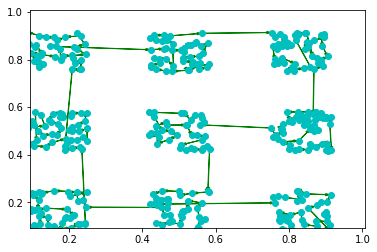

In [162]:
sa.anneal()
sa.visualize_routes()

In [163]:
len(sa.solution_list)

20

In [164]:
sa.best_fitness

0.033486419079471516

In [165]:
[ x[0] for x in sa.solution_list]

[0.033486419079471516,
 0.033511334691950945,
 0.033532547302127645,
 0.03353666004014682,
 0.03355407193617729,
 0.0335540719361773,
 0.0335540719361773,
 0.0335540719361773,
 0.0335540719361773,
 0.033554071936177314,
 0.03355583154824554,
 0.03356458610357779,
 0.03356848146735601,
 0.03358008607837835,
 0.03358008607837835,
 0.03358008607837837,
 0.033588384974761507,
 0.033588384974761507,
 0.03358838497476151,
 0.03358838497476151]

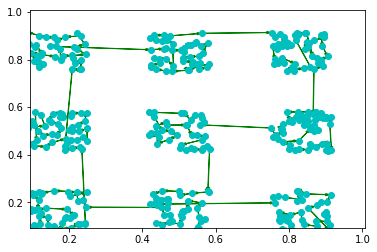

In [166]:
sa.visualize_routes()

In [167]:
sa.best_solution[0:10], sa.best_solution[-10:]

([168, 39, 225, 14, 290, 130, 300, 77, 190, 221],
 [117, 180, 228, 30, 203, 373, 121, 361, 108, 256])

In [168]:
sa.solution_list[0][1][0:10], sa.solution_list[0][1][-10:]

([168, 39, 225, 14, 290, 130, 300, 77, 190, 221],
 [117, 180, 228, 30, 203, 373, 121, 361, 108, 256])

In [169]:
len(sa.best_solution)

400

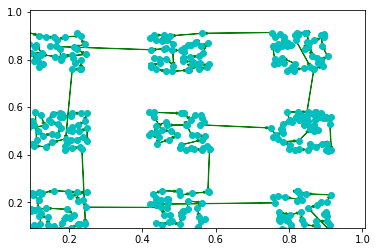

In [172]:
plotTSP([sa.solution_list[-1][1]], sa.coords)